In [4]:
# header files required 
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [10]:
# define class
class RRTStar(object):
    
    
    # init function
    def __init__(self, start, goal):
        """
        Inputs:
        
        start: this is the start coordinate of the robot. It is a tuple of form (x, y).
        goal: this is the goal coordinate of the robot. It is a tuple of form (x, y).
        """
        
        # start variable - tuple of of form (x, y)
        self.start = start
        
        # goal variable - tuple of form (x, y)
        self.goal = goal
        
        # the map size along x and y dimensions in cms (map dimension are from -500 to 500 for both x and y direction)
        # map size is 1000 cm x 1000 cm
        self.xLength = 500
        self.yLength = 500
        
        # clearance variable - distance of the robot from the obstacle
        self.clearance = 0.0
        
        # radius variable - the radius of the robot (taken from turtlebot datasheet)
        self.radius = 0.0
        
        # wheelDistance - the distance between wheels (taken from turtlebot datasheet)
        self.wheelDistance = 34.0
        
        # wheelRadius - the radius of the wheels (taken from turtlebot datasheet)
        self.wheelRadius = 3.8
        
        # costToCome - hashmap to store the distance of the nodes from the start node
        self.costToCome = {}
        
        # path - hashmap used for backtracking from the goal node to the start node
        self.path = {}
        
        # goalThreshold - threshold from goal node
        self.goalThreshold = 15
        
        # vertices of the graph
        self.vertices = []
        
        # step size
        self.stepSize = 6
        
        # step factor
        self.stepFactor = 9
        
        
    # move is valid or not
    def IsValid(self, currX, currY):
        """
        Inputs:
        
        currX - the current x-position of the robot.
        currY - the current y-posiiton of the robot.
        
        Outputs:
        
        True / False depending on whether the nodes lies within the map or not.
        """
        
        nodeInMap = (currX >= (-self.xLength + self.radius + self.clearance) and currX <= (self.xLength - self.radius - self.clearance) and currY >= (-self.yLength + self.radius + self.clearance) and currY <= (self.yLength - self.radius - self.clearance))
        return nodeInMap
    
    
    # checks for an obstacle in the given map
    def IsObstacle(self, row, col):
        """
        Inputs:
        
        row - the current x-position of the robot.
        col - the current y-posiiton of the robot.
        
        Outputs:
        
        True / False depending on whether the nodes lies within obstacle or not.
        """
        
        # constants
        sum_of_c_and_r = self.clearance + self.radius
        sqrt_of_c_and_r = 1.4142 * sum_of_c_and_r
        
        # check circles(obstacles) in the given map
        dist1 = ((row - 200.0) * (row - 200.0) + (col - 300.0) * (col - 300.0)) - ((100 + sum_of_c_and_r) * (100 + sum_of_c_and_r))
        dist2 = ((row - 200.0) * (row - 200.0) + (col + 300.0) * (col + 300.0)) - ((100 + sum_of_c_and_r) * (100 + sum_of_c_and_r))
        dist3 = ((row + 200.0) * (row + 200.0) + (col + 300.0) * (col + 300.0)) - ((100 + sum_of_c_and_r) * (100 + sum_of_c_and_r))
        dist4 = ((row) * (row) + (col) * (col)) - ((100 + sum_of_c_and_r) * (100 + sum_of_c_and_r))
        
        # check first square(obstacle) in the given map
        (x1, y1) = (325 - sqrt_of_c_and_r, -75 - sqrt_of_c_and_r)
        (x2, y2) = (325 - sqrt_of_c_and_r, 75 + sqrt_of_c_and_r)
        (x3, y3) = (475 + sqrt_of_c_and_r, 75 + sqrt_of_c_and_r)
        (x4, y4) = (475 + sqrt_of_c_and_r, -75 - sqrt_of_c_and_r)
        first = ((col - y1) * (x2 - x1)) - ((y2 - y1) * (row - x1))
        second = ((col - y2) * (x3 - x2)) - ((y3 - y2) * (row - x2))
        third = ((col - y3) * (x4 - x3)) - ((y4 - y3) * (row - x3))
        fourth = ((col - y4) * (x1 - x4)) - ((y1 - y4) * (row - x4))
        dist5 = 1
        dist6 = 1
        if(first <= 0 and second <= 0 and third <= 0 and fourth <= 0):
            dist5 = 0
            dist6 = 0
        
        # check second square(obstacle) in the given map
        (x1, y1) = (-325 + sqrt_of_c_and_r, -75 - sqrt_of_c_and_r)
        (x2, y2) = (-325 + sqrt_of_c_and_r, 75 + sqrt_of_c_and_r)
        (x3, y3) = (-475 - sqrt_of_c_and_r, 75 + sqrt_of_c_and_r)
        (x4, y4) = (-475 - sqrt_of_c_and_r, -75 - sqrt_of_c_and_r)
        first = ((col - y1) * (x2 - x1)) - ((y2 - y1) * (row - x1))
        second = ((col - y2) * (x3 - x2)) - ((y3 - y2) * (row - x2))
        third = ((col - y3) * (x4 - x3)) - ((y4 - y3) * (row - x3))
        fourth = ((col - y4) * (x1 - x4)) - ((y1 - y4) * (row - x4))
        dist7 = 1
        dist8 = 1
        if(first >= 0 and second >= 0 and third >= 0 and fourth >= 0):
            dist7 = 0
            dist8 = 0

        # check third square(obstacle) in the given map
        (x1, y1) = (-125 + sqrt_of_c_and_r, 375 + sqrt_of_c_and_r)
        (x2, y2) = (-125 + sqrt_of_c_and_r, 225 - sqrt_of_c_and_r)
        (x3, y3) = (-275 - sqrt_of_c_and_r, 225 - sqrt_of_c_and_r)
        (x4, y4) = (-275 - sqrt_of_c_and_r, 375 + sqrt_of_c_and_r)
        first = ((col - y1) * (x2 - x1)) - ((y2 - y1) * (row - x1))
        second = ((col - y2) * (x3 - x2)) - ((y3 - y2) * (row - x2))
        third = ((col - y3) * (x4 - x3)) - ((y4 - y3) * (row - x3))
        fourth = ((col - y4) * (x1 - x4)) - ((y1 - y4) * (row - x4))
        dist9 = 1
        dist10 = 1
        if(first <= 0 and second <= 0 and third <= 0 and fourth <= 0):
            dist9 = 0
            dist10 = 0
        
        # return true if obstacle, otherwise false
        if(dist1 <= 0 or dist2 <= 0 or dist3 <= 0 or dist4 <= 0 or dist5 == 0 or dist6 == 0 or dist7 == 0 or dist8 == 0 or dist9 == 0 or dist10 == 0):
            return True
        return False
    
    
    # animate path and show the nodes on map
    def animate(self, exploredStates, backtrackStates):
        """
        Inputs:
        
        exploredStates: list of explored states when going from start to  goal node.
        backtrackStates: list of states to go from start to goal node.
        """
        
        startX = []
        startY = []
        endX = []
        endY = []
        explored_startX = []
        explored_startY = []
        explored_endX = []
        explored_endY = []
        fig, ax = plt.subplots()
        plt.xlabel("x-coordinate(in m)")
        plt.ylabel("y-coordinate(in m)")
        plt.grid()
        ax.set_aspect('equal')
        plt.xlim(-self.xLength / 100.0, self.xLength / 100.0)
        plt.ylim(-self.yLength / 100.0, self.yLength / 100.0)
        count = 0
        
        # obstacle space
        obstacleX = []
        obstacleY = []
        size = []
        for index1 in range(-self.xLength, self.xLength):
            for index2 in range(-self.yLength, self.yLength):
                if(self.IsObstacle(index1, index2)):
                    obstacleX.append(index1 / 100.0)
                    obstacleY.append(index2 / 100.0)     
                    size.append(15)      
        obstacleX = np.array(obstacleX)
        obstacleY = np.array(obstacleY)
        plt.scatter(obstacleX, obstacleY, color='b', s=size)

        # explore node space
        for index in range(1, len(exploredStates)):
            parentNode = self.path[exploredStates[index]]
            explored_startX.append(parentNode[0] / 100.0)
            explored_startY.append(parentNode[1] / 100.0)
            explored_endX.append((exploredStates[index][0] - parentNode[0]) / 100.0)
            explored_endY.append((exploredStates[index][1] - parentNode[1]) / 100.0)    
            #if(count % 2000 == 0):
            #    plt.quiver(np.array((explored_startX)), np.array((explored_startY)), np.array((explored_endX)), np.array((explored_endY)), units = 'xy', scale = 1, color = 'g', label = 'Explored region')
            #    plt.savefig("output/phase3/sample" + str(count) + ".png", dpi=1700)
            count = count + 1

        # backtrack space
        if(len(backtrackStates) > 0):
            for index in range(1, len(backtrackStates)):
                startX.append(backtrackStates[index-1][0] / 100.0)
                startY.append(backtrackStates[index-1][1] / 100.0)
                endX.append((backtrackStates[index][0] - backtrackStates[index-1][0]) / 100.0)
                endY.append((backtrackStates[index][1] - backtrackStates[index-1][1]) / 100.0)    
                #if(count % 5 == 0):
                #    plt.quiver(np.array((startX)), np.array((startY)), np.array((endX)), np.array((endY)), units = 'xy', scale = 1, color = 'r', label = 'Backtrack path')
                #    plt.savefig("output/phase3/sample" + str(count) + ".png", dpi=1700)
                count = count + 1

        plt.quiver(np.array((explored_startX)), np.array((explored_startY)), np.array((explored_endX)), np.array((explored_endY)), units = 'xy', scale = 1, color = 'g', label = 'Explored region')
        if(len(backtrackStates) > 0):
            plt.quiver(np.array((startX)), np.array((startY)), np.array((endX)), np.array((endY)), units = 'xy', scale = 1, color = 'r', label = 'Backtrack path')
        #plt.savefig("output.png", dpi=1700)
        plt.legend()
        plt.show()
        plt.close()
    
    
    # eucledian heuristic
    def euc_heuristic(self, point1, point2):
        """
        Inputs:
        
        point1: the first position of the robot, tuple (x, y).
        point2: the second posiiton of the robot, tuple (x, y).
        
        Output:
        
        Returns the eucledian distance between point1 and point2
        """
        
        return (np.sqrt(((point2[0] - point1[0]) ** 2) + ((point2[1] - point1[1]) ** 2)))
    
    
    # random position generator
    def getRandomPosition(self):
        """
        Output:
        
        Returns the random node
        """
        
        randX = round(random.uniform((-self.xLength + self.radius + self.clearance), (self.xLength - self.radius - self.clearance)), 2)
        randY = round(random.uniform((-self.yLength + self.radius + self.clearance), (self.yLength - self.radius - self.clearance)), 2)
        return (randX, randY)
    
    
    # nearest neighbour in the graph
    def getNearestNeighbour(self, currX, currY):
        """
        Inputs:
        
        currX: the current x-position of the robot.
        currY: the current y-posiiton of the robot.
        
        Outputs:
        
        nearestVertex: the nearest node in the array of vertices of the graph
        """
        
        # set vertex to -1
        minDistance = float('inf')
        nearestVertex = -1
        
        # loop through vertices of graph
        for vertex in self.vertices:
            distance = self.euc_heuristic(vertex, (currX, currY))
            if(distance < minDistance):
                minDistance = distance
                nearestVertex = vertex
        
        # return nearest vertex
        return nearestVertex
    
    
    # check obstacle between points
    def checkObstacleBetweenPoints(self, point1, point2):
        """
        Inputs:
        
        point1: the first position of the robot, tuple (x, y).
        point2: the second posiiton of the robot, tuple (x, y).
        
        Output:
        
        Returns True/False, whether an obstacle occurs between point1 and point2 or not
        """
        
        # get diff1 and diff2
        diff1 = point2[0] - point1[0]
        diff2 = point2[1] - point1[1]
        
        # points to check for obstacle
        points_to_check = []
        points_to_check.append(point1)
        
        # get value of diff
        if(np.abs(diff1) > np.abs(diff2)):
            diff = np.abs(diff1)
        else:
            diff = np.abs(diff2)
        
        for index in range(1, int(np.abs(diff))):
            point = (point1[0] + (index * diff1 / np.abs(diff)), point1[1] + (index * diff2 / np.abs(diff)))
            points_to_check.append(point)
        
        # check for obstacle
        for point in points_to_check:
            if(self.IsObstacle(point[0], point[1]) or self.IsValid(point[0], point[1]) == False):
                return True
        return False
    
    
    # new node
    def getNewNode(self, x_rand, x_nearest):
        """
        Inputs:
        
        x_rand: the random node
        x_nearest: the nearest node to the x_rand
        
        Outputs:
        
        newNode: the Xnew node at a distance of self.stepSize from x_nearest and in the direction of x_rand
        """
        
        # slope of line joining x_rand and x_nearest
        slope = (x_rand[1] - x_nearest[1]) / (x_rand[0] - x_nearest[0])
        factor = self.stepSize * np.sqrt(1.0 / (1.0 + (slope ** 2)))
        
        # two points possible
        point_1 = (round(x_nearest[0] + factor, 2), round(x_nearest[1] + (slope * factor), 2))
        point_2 = (round(x_nearest[0] - factor, 2), round(x_nearest[1] - (slope * factor), 2))
        flag1 = False
        flag2 = False
        
        # check for obstacles
        if(self.checkObstacleBetweenPoints(x_nearest, point_1)):
            flag1 = True
        if(self.checkObstacleBetweenPoints(x_nearest, point_2)):
            flag2 = True
        
        # return point with minimum distance to random node
        distance_1 = self.euc_heuristic(x_rand, point_1)
        distance_2 = self.euc_heuristic(x_rand, point_2)
        if(distance_1 < distance_2):
            return (flag1, point_1)
        else:
            return (flag2, point_2)
    
    
    # get neighbourhood
    def getNeighbourhood(self, x_new):
        """
        Inputs:
        
        x_new: the new node
        
        Outputs:
        
        neighbourhood: the list of nodes in the neighbourhood of x_new
        """
        
        # iterate through the vertices and get nodes within a certain radius
        neighbourhood = []
        for index in range(0, len(self.vertices)):
            dist = self.euc_heuristic(x_new, self.vertices[index])
            if(dist < self.stepFactor):
                neighbourhood.append(self.vertices[index])
        return neighbourhood
    
    
    # get neighbourhood parent
    def getNeighbourhoodParent(self, neighbourhood):
        """
        Inputs:
        
        neighbourhood: the list of nodes in the neighbourhood of x_new
        
        Outputs:
        
        parent: the node that is the ideal parent for the x_new node
        """
        
        dist = self.costToCome[neighbourhood[0]]
        parent = neighbourhood[0]
        for index in range(1, len(neighbourhood)):
            curr_dist = self.costToCome[neighbourhood[index]]
            if(curr_dist < dist):
                dist = curr_dist
                parent = neighbourhood[index]
        return parent
    
    
    # rrt-star algo
    def search(self):
        """
        Outputs:
        
        exploredStates: the states explored when moving from start node to goal node.
        backtrackStates: the path from start node to goal node.
        actions: list containing the (dvx, dvy) values for each possible node between start and goal node.
        distance: the total distance between start node and goal node.
        """
        
        # initial steps for rrt-star algo
        self.costToCome[self.start] = 0
        self.vertices.append(self.start)
        backtrackNode = None
        
        # run the rrt-star algo
        for step in range(0, 10000):
            
            # get random node
            (x_rand_x, x_rand_y) = self.getRandomPosition()
            x_rand = (x_rand_x, x_rand_y)
            
            # get nearest node
            (x_nearest_x, x_nearest_y) = self.getNearestNeighbour(x_rand_x, x_rand_y)
            x_nearest = (x_nearest_x, x_nearest_y)
            
            # check whether x_nearest[0] == x_rand[0] or x_nearest[1] == x_rand[1]
            if((x_nearest[0] == x_rand[0]) or (x_nearest[1] == x_rand[1])):
                continue
    
            # get new node between x_nearest and x_rand
            (flag, x_new) = self.getNewNode(x_rand, x_nearest)
            if(flag == True):
                continue
            
            # get neighbourhood region for x_new
            neighbourhood = self.getNeighbourhood(x_new)
            
            # get parent for the neighbourhood region
            parent = self.getNeighbourhoodParent(neighbourhood)
            x_nearest = parent
            
            # check obstacle between x_nearest and x_new
            if(self.checkObstacleBetweenPoints(x_nearest, x_new)):
                continue
            
            # add x_new to graph
            self.vertices.append(x_new)
            self.path[x_new] = x_nearest
            self.costToCome[x_new] = self.costToCome[x_nearest] + self.euc_heuristic(x_nearest, x_new)
            
            # rewire graph
            for index in range(0, len(neighbourhood)):
                distance_from_start = self.costToCome[x_new] + self.euc_heuristic(x_new, neighbourhood[index])
                if(distance_from_start < self.costToCome[neighbourhood[index]]):
                    self.costToCome[neighbourhood[index]] = distance_from_start
                    self.path[neighbourhood[index]] = x_new
            
            # check distance between goal and x_new
            dist_from_goal = self.euc_heuristic(x_new, self.goal)
            if(dist_from_goal <= self.goalThreshold):
                backtrackNode = x_new
                break
                
        # backtrack path
        if(backtrackNode == None):
            return (self.vertices, [])
        
        backtrackStates = []
        while(backtrackNode != self.start):
            backtrackStates.append(backtrackNode)
            backtrackNode = self.path[backtrackNode]
        backtrackStates.append(self.start)
        backtrackStates = list(reversed(backtrackStates))
        return (self.vertices, backtrackStates)

In [11]:
start = (-400, -300)
goal = (400, 300)

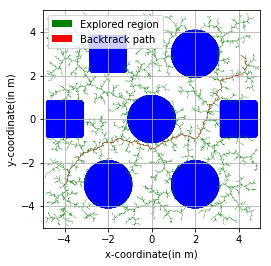

5854
218


In [12]:
rrt = RRTStar(start, goal)
if(rrt.IsValid(start[0], start[1])):
    if(rrt.IsValid(goal[0], goal[1])):
        if(rrt.IsObstacle(start[0],start[1]) == False):
            if(rrt.IsObstacle(goal[0], goal[1]) == False):
                (explored_states, backtrack_states) = rrt.search()
                
                # animate the path
                rrt.animate(explored_states, backtrack_states)
                
                print(len(explored_states))
                print(len(backtrack_states))
            else:
                print("The entered goal node is an obstacle ")
                print("Please check README.md file for running rrt_star.py file.")
        else:
            print("The entered start node is an obstacle ")
            print("Please check README.md file for running rrt_star.py file.")
    else:
        print("The entered goal node outside the map ")
        print("Please check README.md file for running rrt_star.py file.")
else:
    print("The entered start node is outside the map ")
    print("Please check README.md file for running rrt_star.py file.")

In [17]:
# define class
class InformedRRTStar(object):
    
    
    # init function
    def __init__(self, start, goal):
        """
        Inputs:
        
        start: this is the start coordinate of the robot. It is a tuple of form (x, y).
        goal: this is the goal coordinate of the robot. It is a tuple of form (x, y).
        """
        
        # start variable - tuple of of form (x, y)
        self.start = start
        
        # goal variable - tuple of form (x, y)
        self.goal = goal
        
        # the map size along x and y dimensions in cms (map dimension are from -500 to 500 for both x and y direction)
        # map size is 1000 cm x 1000 cm
        self.xLength = 500
        self.yLength = 500
        
        # clearance variable - distance of the robot from the obstacle
        self.clearance = 0.0
        
        # radius variable - the radius of the robot (taken from turtlebot datasheet)
        self.radius = 0.0
        
        # wheelDistance - the distance between wheels (taken from turtlebot datasheet)
        self.wheelDistance = 34.0
        
        # wheelRadius - the radius of the wheels (taken from turtlebot datasheet)
        self.wheelRadius = 3.8
        
        # costToCome - hashmap to store the distance of the nodes from the start node
        self.costToCome = {}
        
        # path - hashmap used for backtracking from the goal node to the start node
        self.path = {}
        
        # goalThreshold - threshold from goal node
        self.goalThreshold = 15
        
        # vertices of the graph
        self.vertices = []
        
        # step size
        self.stepSize = 6
        
        # step factor
        self.stepFactor = 9
        
        
    # move is valid or not
    def IsValid(self, currX, currY):
        """
        Inputs:
        
        currX - the current x-position of the robot.
        currY - the current y-posiiton of the robot.
        
        Outputs:
        
        True / False depending on whether the nodes lies within the map or not.
        """
        
        nodeInMap = (currX >= (-self.xLength + self.radius + self.clearance) and currX <= (self.xLength - self.radius - self.clearance) and currY >= (-self.yLength + self.radius + self.clearance) and currY <= (self.yLength - self.radius - self.clearance))
        return nodeInMap
    
    
    # checks for an obstacle in the given map
    def IsObstacle(self, row, col):
        """
        Inputs:
        
        row - the current x-position of the robot.
        col - the current y-posiiton of the robot.
        
        Outputs:
        
        True / False depending on whether the nodes lies within obstacle or not.
        """
        
        # constants
        sum_of_c_and_r = self.clearance + self.radius
        sqrt_of_c_and_r = 1.4142 * sum_of_c_and_r
        
        # check circles(obstacles) in the given map
        dist1 = ((row - 200.0) * (row - 200.0) + (col - 300.0) * (col - 300.0)) - ((100 + sum_of_c_and_r) * (100 + sum_of_c_and_r))
        dist2 = ((row - 200.0) * (row - 200.0) + (col + 300.0) * (col + 300.0)) - ((100 + sum_of_c_and_r) * (100 + sum_of_c_and_r))
        dist3 = ((row + 200.0) * (row + 200.0) + (col + 300.0) * (col + 300.0)) - ((100 + sum_of_c_and_r) * (100 + sum_of_c_and_r))
        dist4 = ((row) * (row) + (col) * (col)) - ((100 + sum_of_c_and_r) * (100 + sum_of_c_and_r))
        
        # check first square(obstacle) in the given map
        (x1, y1) = (325 - sqrt_of_c_and_r, -75 - sqrt_of_c_and_r)
        (x2, y2) = (325 - sqrt_of_c_and_r, 75 + sqrt_of_c_and_r)
        (x3, y3) = (475 + sqrt_of_c_and_r, 75 + sqrt_of_c_and_r)
        (x4, y4) = (475 + sqrt_of_c_and_r, -75 - sqrt_of_c_and_r)
        first = ((col - y1) * (x2 - x1)) - ((y2 - y1) * (row - x1))
        second = ((col - y2) * (x3 - x2)) - ((y3 - y2) * (row - x2))
        third = ((col - y3) * (x4 - x3)) - ((y4 - y3) * (row - x3))
        fourth = ((col - y4) * (x1 - x4)) - ((y1 - y4) * (row - x4))
        dist5 = 1
        dist6 = 1
        if(first <= 0 and second <= 0 and third <= 0 and fourth <= 0):
            dist5 = 0
            dist6 = 0
        
        # check second square(obstacle) in the given map
        (x1, y1) = (-325 + sqrt_of_c_and_r, -75 - sqrt_of_c_and_r)
        (x2, y2) = (-325 + sqrt_of_c_and_r, 75 + sqrt_of_c_and_r)
        (x3, y3) = (-475 - sqrt_of_c_and_r, 75 + sqrt_of_c_and_r)
        (x4, y4) = (-475 - sqrt_of_c_and_r, -75 - sqrt_of_c_and_r)
        first = ((col - y1) * (x2 - x1)) - ((y2 - y1) * (row - x1))
        second = ((col - y2) * (x3 - x2)) - ((y3 - y2) * (row - x2))
        third = ((col - y3) * (x4 - x3)) - ((y4 - y3) * (row - x3))
        fourth = ((col - y4) * (x1 - x4)) - ((y1 - y4) * (row - x4))
        dist7 = 1
        dist8 = 1
        if(first >= 0 and second >= 0 and third >= 0 and fourth >= 0):
            dist7 = 0
            dist8 = 0

        # check third square(obstacle) in the given map
        (x1, y1) = (-125 + sqrt_of_c_and_r, 375 + sqrt_of_c_and_r)
        (x2, y2) = (-125 + sqrt_of_c_and_r, 225 - sqrt_of_c_and_r)
        (x3, y3) = (-275 - sqrt_of_c_and_r, 225 - sqrt_of_c_and_r)
        (x4, y4) = (-275 - sqrt_of_c_and_r, 375 + sqrt_of_c_and_r)
        first = ((col - y1) * (x2 - x1)) - ((y2 - y1) * (row - x1))
        second = ((col - y2) * (x3 - x2)) - ((y3 - y2) * (row - x2))
        third = ((col - y3) * (x4 - x3)) - ((y4 - y3) * (row - x3))
        fourth = ((col - y4) * (x1 - x4)) - ((y1 - y4) * (row - x4))
        dist9 = 1
        dist10 = 1
        if(first <= 0 and second <= 0 and third <= 0 and fourth <= 0):
            dist9 = 0
            dist10 = 0
        
        # return true if obstacle, otherwise false
        if(dist1 <= 0 or dist2 <= 0 or dist3 <= 0 or dist4 <= 0 or dist5 == 0 or dist6 == 0 or dist7 == 0 or dist8 == 0 or dist9 == 0 or dist10 == 0):
            return True
        return False
    
    
    # animate path and show the nodes on map
    def animate(self, exploredStates, backtrackStates):
        """
        Inputs:
        
        exploredStates: list of explored states when going from start to  goal node.
        backtrackStates: list of states to go from start to goal node.
        """
        
        startX = []
        startY = []
        endX = []
        endY = []
        explored_startX = []
        explored_startY = []
        explored_endX = []
        explored_endY = []
        fig, ax = plt.subplots()
        plt.xlabel("x-coordinate(in m)")
        plt.ylabel("y-coordinate(in m)")
        plt.grid()
        ax.set_aspect('equal')
        plt.xlim(-self.xLength / 100.0, self.xLength / 100.0)
        plt.ylim(-self.yLength / 100.0, self.yLength / 100.0)
        count = 0
        
        # obstacle space
        obstacleX = []
        obstacleY = []
        size = []
        for index1 in range(-self.xLength, self.xLength):
            for index2 in range(-self.yLength, self.yLength):
                if(self.IsObstacle(index1, index2)):
                    obstacleX.append(index1 / 100.0)
                    obstacleY.append(index2 / 100.0)     
                    size.append(15)      
        obstacleX = np.array(obstacleX)
        obstacleY = np.array(obstacleY)
        plt.scatter(obstacleX, obstacleY, color='b', s=size)

        # explore node space
        for index in range(1, len(exploredStates)):
            parentNode = self.path[exploredStates[index]]
            explored_startX.append(parentNode[0] / 100.0)
            explored_startY.append(parentNode[1] / 100.0)
            explored_endX.append((exploredStates[index][0] - parentNode[0]) / 100.0)
            explored_endY.append((exploredStates[index][1] - parentNode[1]) / 100.0)    
            #if(count % 2000 == 0):
            #    plt.quiver(np.array((explored_startX)), np.array((explored_startY)), np.array((explored_endX)), np.array((explored_endY)), units = 'xy', scale = 1, color = 'g', label = 'Explored region')
            #    plt.savefig("output/phase3/sample" + str(count) + ".png", dpi=1700)
            count = count + 1

        # backtrack space
        if(len(backtrackStates) > 0):
            for index in range(1, len(backtrackStates)):
                startX.append(backtrackStates[index-1][0] / 100.0)
                startY.append(backtrackStates[index-1][1] / 100.0)
                endX.append((backtrackStates[index][0] - backtrackStates[index-1][0]) / 100.0)
                endY.append((backtrackStates[index][1] - backtrackStates[index-1][1]) / 100.0)    
                #if(count % 5 == 0):
                #    plt.quiver(np.array((startX)), np.array((startY)), np.array((endX)), np.array((endY)), units = 'xy', scale = 1, color = 'r', label = 'Backtrack path')
                #    plt.savefig("output/phase3/sample" + str(count) + ".png", dpi=1700)
                count = count + 1

        plt.quiver(np.array((explored_startX)), np.array((explored_startY)), np.array((explored_endX)), np.array((explored_endY)), units = 'xy', scale = 1, color = 'g', label = 'Explored region')
        if(len(backtrackStates) > 0):
            plt.quiver(np.array((startX)), np.array((startY)), np.array((endX)), np.array((endY)), units = 'xy', scale = 1, color = 'r', label = 'Backtrack path')
        #plt.savefig("output.png", dpi=1700)
        plt.legend()
        plt.show()
        plt.close()
    
    
    # eucledian heuristic
    def euc_heuristic(self, point1, point2):
        """
        Inputs:
        
        point1: the first position of the robot, tuple (x, y).
        point2: the second posiiton of the robot, tuple (x, y).
        
        Output:
        
        Returns the eucledian distance between point1 and point2
        """
        
        return (np.sqrt(((point2[0] - point1[0]) ** 2) + ((point2[1] - point1[1]) ** 2)))
    
    
    # random position generator
    def getRandomPosition(self, cMax, cMin, xCenter, c_matrix):
        """
        Output:
        
        Returns the random node
        """
        
        (randX, randY) = (None, None)
        if(cMax < float('inf')):
            
            # generate r matrix
            r_matrix = [(cMax / 2.0), (np.sqrt((cMax ** 2) - (cMin ** 2)) / 2.0), (np.sqrt((cMax ** 2) - (cMin ** 2)) / 2.0)]
            
            # generate l matrix
            l_matrix = np.diag(r_matrix)
            
            # generate xBall matrix
            a = random.random()
            b = random.random()
            
            if(b < a):
                a, b = b, a
            
            sample = (b * np.cos(2 * np.pi * a / b), b * np.sin(2 * np.pi * a / b))
            xBall = np.array([[sample[0]], [sample[1]], [0]])
            rand = np.dot(np.dot(c_matrix, l_matrix), xBall) + xCenter
            randX = round(rand[(0, 0)], 2)
            randY = round(rand[(1, 0)], 2)
        else:
            randX = round(random.uniform((-self.xLength + self.radius + self.clearance), (self.xLength - self.radius - self.clearance)), 2)
            randY = round(random.uniform((-self.yLength + self.radius + self.clearance), (self.yLength - self.radius - self.clearance)), 2)
        return (randX, randY)
    
    
    # nearest neighbour in the graph
    def getNearestNeighbour(self, currX, currY):
        """
        Inputs:
        
        currX: the current x-position of the robot.
        currY: the current y-posiiton of the robot.
        
        Outputs:
        
        nearestVertex: the nearest node in the array of vertices of the graph
        """
        
        # set vertex to -1
        minDistance = float('inf')
        nearestVertex = -1
        
        # loop through vertices of graph
        for vertex in self.vertices:
            distance = self.euc_heuristic(vertex, (currX, currY))
            if(distance < minDistance):
                minDistance = distance
                nearestVertex = vertex
        
        # return nearest vertex
        return nearestVertex
    
    
    # check obstacle between points
    def checkObstacleBetweenPoints(self, point1, point2):
        """
        Inputs:
        
        point1: the first position of the robot, tuple (x, y).
        point2: the second posiiton of the robot, tuple (x, y).
        
        Output:
        
        Returns True/False, whether an obstacle occurs between point1 and point2 or not
        """
        
        # get diff1 and diff2
        diff1 = point2[0] - point1[0]
        diff2 = point2[1] - point1[1]
        
        # points to check for obstacle
        points_to_check = []
        points_to_check.append(point1)
        
        # get value of diff
        if(np.abs(diff1) > np.abs(diff2)):
            diff = np.abs(diff1)
        else:
            diff = np.abs(diff2)
        
        for index in range(1, int(np.abs(diff))):
            point = (point1[0] + (index * diff1 / np.abs(diff)), point1[1] + (index * diff2 / np.abs(diff)))
            points_to_check.append(point)
        
        # check for obstacle
        for point in points_to_check:
            if(self.IsObstacle(point[0], point[1]) or self.IsValid(point[0], point[1]) == False):
                return True
        return False
    
    
    # new node
    def getNewNode(self, x_rand, x_nearest):
        """
        Inputs:
        
        x_rand: the random node
        x_nearest: the nearest node to the x_rand
        
        Outputs:
        
        newNode: the Xnew node at a distance of self.stepSize from x_nearest and in the direction of x_rand
        """
        
        # slope of line joining x_rand and x_nearest
        slope = (x_rand[1] - x_nearest[1]) / (x_rand[0] - x_nearest[0])
        factor = self.stepSize * np.sqrt(1.0 / (1.0 + (slope ** 2)))
        
        # two points possible
        point_1 = (round(x_nearest[0] + factor, 2), round(x_nearest[1] + (slope * factor), 2))
        point_2 = (round(x_nearest[0] - factor, 2), round(x_nearest[1] - (slope * factor), 2))
        flag1 = False
        flag2 = False
        
        # check for obstacles
        if(self.checkObstacleBetweenPoints(x_nearest, point_1)):
            flag1 = True
        if(self.checkObstacleBetweenPoints(x_nearest, point_2)):
            flag2 = True
        
        # return point with minimum distance to random node
        distance_1 = self.euc_heuristic(x_rand, point_1)
        distance_2 = self.euc_heuristic(x_rand, point_2)
        if(distance_1 < distance_2):
            return (flag1, point_1)
        else:
            return (flag2, point_2)
    
    
    # get neighbourhood
    def getNeighbourhood(self, x_new):
        """
        Inputs:
        
        x_new: the new node
        
        Outputs:
        
        neighbourhood: the list of nodes in the neighbourhood of x_new
        """
        
        # iterate through the vertices and get nodes within a certain radius
        neighbourhood = []
        for index in range(0, len(self.vertices)):
            dist = self.euc_heuristic(x_new, self.vertices[index])
            if(dist < self.stepFactor):
                neighbourhood.append(self.vertices[index])
        return neighbourhood
    
    
    # get neighbourhood parent
    def getNeighbourhoodParent(self, neighbourhood):
        """
        Inputs:
        
        neighbourhood: the list of nodes in the neighbourhood of x_new
        
        Outputs:
        
        parent: the node that is the ideal parent for the x_new node
        """
        
        dist = self.costToCome[neighbourhood[0]]
        parent = neighbourhood[0]
        for index in range(1, len(neighbourhood)):
            curr_dist = self.costToCome[neighbourhood[index]]
            if(curr_dist < dist):
                dist = curr_dist
                parent = neighbourhood[index]
        return parent
    
    
    # rrt-star algo
    def search(self):
        """
        Outputs:
        
        exploredStates: the states explored when moving from start node to goal node.
        backtrackStates: the path from start node to goal node.
        actions: list containing the (dvx, dvy) values for each possible node between start and goal node.
        distance: the total distance between start node and goal node.
        """
        
        # initial steps for rrt-star algo
        self.costToCome[self.start] = 0
        self.vertices.append(self.start)
        backtrackStates = []
        cBest = float('inf')
        pathLen = float('inf')
        cMin = np.sqrt((self.start[0] - self.goal[0]) ** 2 + (self.start[1] - self.goal[1]) ** 2)
        xCenter = np.matrix([[(self.start[0] + self.goal[0]) / 2.0], [(self.start[1] + self.goal[1]) / 2.0], [0]])
        m_matrix = np.dot(np.matrix([[(self.goal[0] - self.start[0]) / cMin], [(self.goal[1] - self.start[1]) / cMin], [0]]) , np.matrix([1.0, 0.0, 0.0]))
        u_matrix, s_matrix, vh_matrix = np.linalg.svd(m_matrix, 1, 1)
        c_matrix = np.dot(np.dot(u_matrix, np.diag([1.0, 1.0, np.linalg.det(u_matrix) * np.linalg.det(np.transpose(vh_matrix))])), vh_matrix)
        
        # run the rrt-star algo
        for step in range(0, 15000):
            
            # get random node
            (x_rand_x, x_rand_y) = self.getRandomPosition(cBest, cMin, xCenter, c_matrix)
            x_rand = (x_rand_x, x_rand_y)
            
            # get nearest node
            (x_nearest_x, x_nearest_y) = self.getNearestNeighbour(x_rand_x, x_rand_y)
            x_nearest = (x_nearest_x, x_nearest_y)
            
            # check whether x_nearest[0] == x_rand[0] or x_nearest[1] == x_rand[1]
            if((x_nearest[0] == x_rand[0]) or (x_nearest[1] == x_rand[1])):
                continue
    
            # get new node between x_nearest and x_rand
            (flag, x_new) = self.getNewNode(x_rand, x_nearest)
            if(flag == True):
                continue
            
            # get neighbourhood region for x_new
            neighbourhood = self.getNeighbourhood(x_new)
            
            # get parent for the neighbourhood region
            parent = self.getNeighbourhoodParent(neighbourhood)
            x_nearest = parent
            
            # check obstacle between x_nearest and x_new
            if(self.checkObstacleBetweenPoints(x_nearest, x_new)):
                continue
            
            # add x_new to graph
            self.vertices.append(x_new)
            self.path[x_new] = x_nearest
            self.costToCome[x_new] = self.costToCome[x_nearest] + self.euc_heuristic(x_nearest, x_new)
            
            # rewire graph
            for index in range(0, len(neighbourhood)):
                distance_from_start = self.costToCome[x_new] + self.euc_heuristic(x_new, neighbourhood[index])
                if(distance_from_start < self.costToCome[neighbourhood[index]]):
                    self.costToCome[neighbourhood[index]] = distance_from_start
                    self.path[neighbourhood[index]] = x_new
            
            # check distance between goal and x_new
            dist_from_goal = self.euc_heuristic(x_new, self.goal)
            if(dist_from_goal <= self.goalThreshold):
                backtrackNode = x_new
                
                # backtrack path
                temp_path = []
                temp_len = self.costToCome[backtrackNode]
                while(backtrackNode != self.start):
                    temp_path.append(backtrackNode)
                    backtrackNode = self.path[backtrackNode]
                temp_path.append(self.start)
                temp_path = list(reversed(temp_path))
                
                # update path if length minimal
                if(cBest > temp_len):
                    cBest = temp_len
                    backtrackStates = temp_path
        
        # return explored and backtrack states
        return (self.vertices, backtrackStates)

In [18]:
start = (-400, -300)
goal = (400, 300)

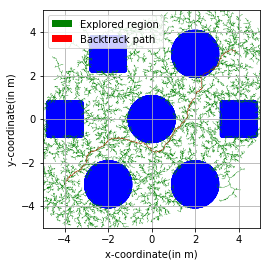

11288
198


In [19]:
rrt = InformedRRTStar(start, goal)
if(rrt.IsValid(start[0], start[1])):
    if(rrt.IsValid(goal[0], goal[1])):
        if(rrt.IsObstacle(start[0],start[1]) == False):
            if(rrt.IsObstacle(goal[0], goal[1]) == False):
                (explored_states, backtrack_states) = rrt.search()
                
                # animate the path
                rrt.animate(explored_states, backtrack_states)
                
                print(len(explored_states))
                print(len(backtrack_states))
            else:
                print("The entered goal node is an obstacle ")
                print("Please check README.md file for running informed_rrt_star.py file.")
        else:
            print("The entered start node is an obstacle ")
            print("Please check README.md file for running informed_rrt_star.py file.")
    else:
        print("The entered goal node outside the map ")
        print("Please check README.md file for running informed_rrt_star.py file.")
else:
    print("The entered start node is outside the map ")
    print("Please check README.md file for running informed_rrt_star.py file.")